In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Saving figure some_digit_plot


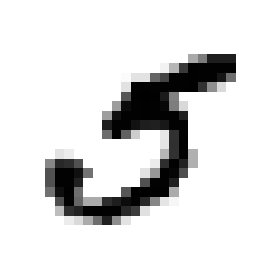

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


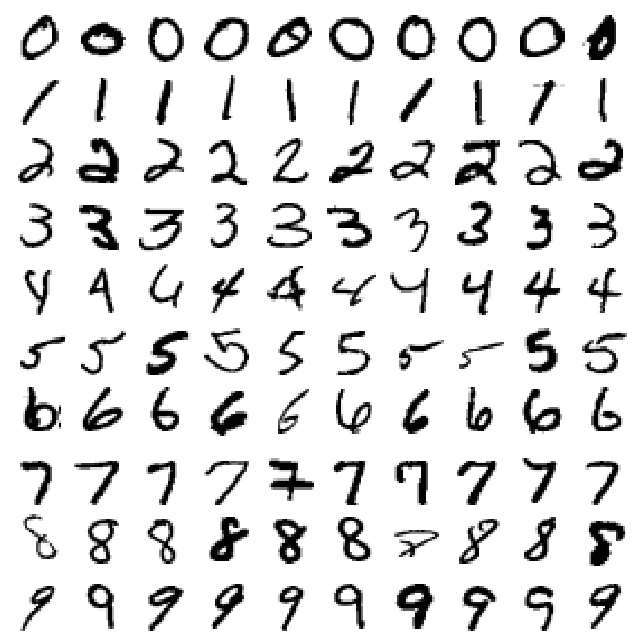

In [10]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [11]:
y[36000]

5

In [12]:
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/pramitdutta/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96225
0.9645
0.94765


In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]])

In [24]:
y_train_perfect_predictions = y_train_5

In [25]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [30]:
y_some_digit_pred

array([ True])

In [31]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [32]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.5.
The scikit-learn version is 0.22.1.


In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [34]:
y_scores.shape

(60000,)

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


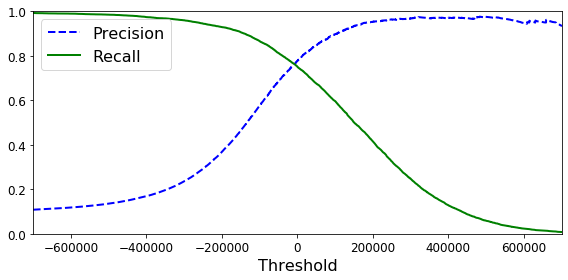

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

In [38]:
y_train_pred_90 = (y_scores > 70000)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

Saving figure precision_vs_recall_plot


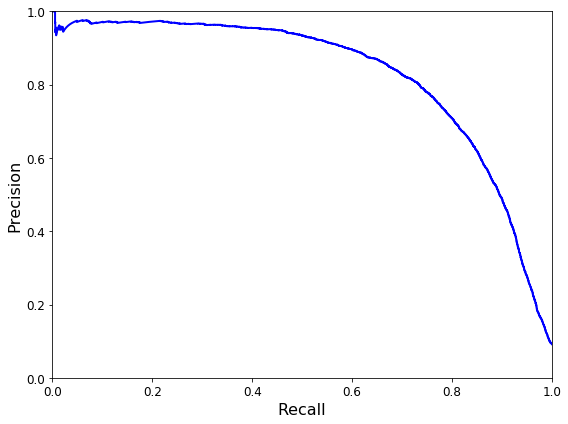

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [43]:
y_train_pred_90=(y_scores>=threshold_90_precision)

In [44]:
precision_score(y_train_5,y_train_pred_90)

0.9001128668171557

In [45]:
recall_score(y_train_5,y_train_pred_90)

0.5884523150710201

In [46]:
from sklearn.metrics import roc_curve

In [47]:
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

Saving figure roc_curve_plot


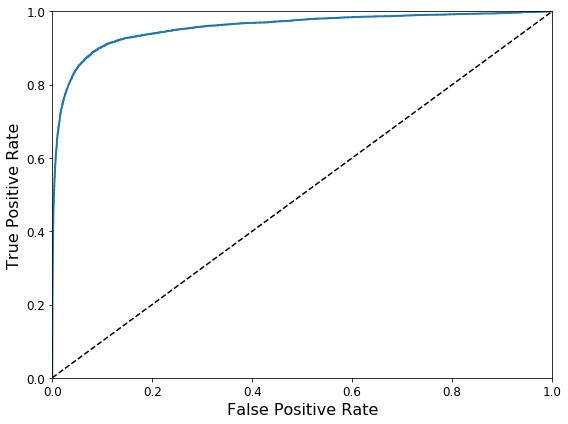

In [48]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
save_fig('roc_curve_plot')
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
forest_clf = RandomForestClassifier(random_state=42)

In [53]:
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_5,
                                  cv=3,method='predict_proba')

In [54]:
y_scores_forest = y_proba_forest[:,1]

In [55]:
fpr_forest,tpr_forest,threshold_forest = roc_curve(y_train_5,y_scores_forest)

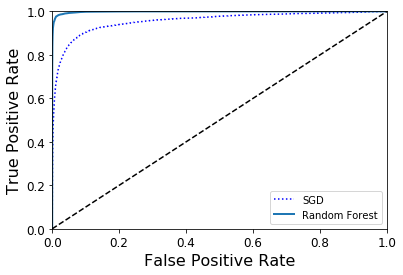

In [56]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [57]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983730844244434

In [58]:
from sklearn.svm import SVC

In [59]:
svm_clf=SVC()

In [60]:
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[7.28571996, 1.72093495, 5.77012507, 8.29266783, 0.7230706 ,
        9.31337785, 0.71946461, 4.74166507, 1.73222778, 3.73632261]])

In [62]:
np.argmax(some_digit_scores)

5

In [63]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [64]:
svm_clf.classes_[5]

5

In [65]:
from sklearn.multiclass import OneVsRestClassifier

In [66]:
ovr_clf = OneVsRestClassifier(SVC())

In [67]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [68]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [69]:
len(ovr_clf.estimators_)

10

In [70]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [71]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [72]:
sgd_clf.decision_function([some_digit])

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [73]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.8618, 0.8675, 0.8389])

In [74]:
from sklearn.preprocessing import StandardScaler

In [75]:
scaler=StandardScaler()

In [76]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [77]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.9091 , 0.90955, 0.9062 ])

In [78]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)

In [79]:
conf_mx = confusion_matrix(y_train,y_train_pred)

In [80]:
conf_mx

array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]])

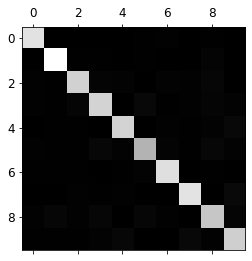

In [81]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [82]:
row_sums = conf_mx.sum(axis=1,keepdims=True)

In [83]:
norm_conf_mx = conf_mx/row_sums

In [84]:
norm_conf_mx

array([[9.67077495e-01, 5.06500084e-04, 3.03900051e-03, 1.68833361e-03,
        1.85716698e-03, 8.10400135e-03, 9.11700152e-03, 1.68833361e-03,
        6.41566774e-03, 5.06500084e-04],
       [2.96647879e-04, 9.59952536e-01, 6.37792940e-03, 4.00474637e-03,
        8.89943637e-04, 6.08128152e-03, 8.89943637e-04, 1.33491546e-03,
        1.83921685e-02, 1.77988727e-03],
       [9.90265190e-03, 6.54582075e-03, 8.89560255e-01, 1.72876804e-02,
        1.61127895e-02, 4.02819738e-03, 1.66163142e-02, 9.56696878e-03,
        2.80295401e-02, 2.34978181e-03],
       [9.78633176e-03, 6.85043223e-03, 2.16930354e-02, 8.73756320e-01,
        6.52422117e-04, 3.47414777e-02, 5.70869352e-03, 8.48148752e-03,
        2.20192465e-02, 1.63105529e-02],
       [2.39643958e-03, 4.79287915e-03, 5.64875043e-03, 1.54056830e-03,
        9.18521054e-01, 1.36939404e-03, 9.58575830e-03, 5.64875043e-03,
        1.50633345e-02, 3.54330709e-02],
       [1.25438111e-02, 9.03892271e-03, 5.53403431e-03, 3.63401586e-02,
   

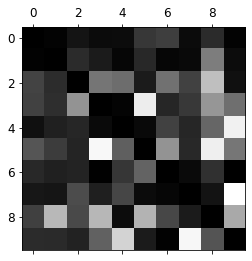

In [85]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
y_train_large = y_train>=7
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [88]:
knn_clf = KNeighborsClassifier()

In [89]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [90]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [91]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)

In [92]:
f1_score(y_multilabel,y_train_knn_pred,average='macro')

0.97709078477525